<a href="https://colab.research.google.com/github/olgapoletkina/sf_data_science/blob/main/Home_work_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://colab.research.google.com/drive/1QDCnKCwvKlvE3cvQtYqVgkvzs_QntRbx?usp=sharing

## Задача

В приложенных файлах вы увидите данные по прохождению студентами тестов на образовательной платформе. Такие данные могут быть использованы для построения персонализированных ИИ-ассистентов для поддержки обучения студента. На текущем этапе сосредоточимся на начальном этапе — сборе и подготовке данных.

**Вам необходимо:**
Используя библиотеку pandas (или аналоги), проанализировать как можно больше характеристик, влияющих на успеваемость студентов.

## Описание данных

### test.csv

- **row_id**: (int64) ID code for the row.
- **timestamp**: (int64) The time in milliseconds between this user interaction and the first event completion from that user.
- **user_id**: (int32) ID code for the user.
- **content_id**: (int16) ID code for the user interaction.
- **content_type_id**: (int8)
  - 0 if the event was a question being posed to the user.
  - 1 if the event was the user watching a lecture.
- **task_container_id**: (int16) ID code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a `task_container_id`.
- **user_answer**: (int8) The user's answer to the question, if any. Read -1 as null, for lectures.
- **answered_correctly**: (int8) If the user responded correctly. Read -1 as null, for lectures.
- **prior_question_elapsed_time**: (float32) The average time in milliseconds it took a user to answer each question in the previous question bundle, ignoring any lectures in between. This value is null for a user's first question bundle or lecture.
  - Note that the time is the average time a user took to solve each question in the previous bundle.
- **prior_question_had_explanation**: (bool) Whether or not the user saw an explanation and the correct response(s) after answering the previous question bundle, ignoring any lectures in between. The value is shared across a single question bundle and is null for a user's first question bundle or lecture. Typically, the first several questions a user sees were part of an onboarding diagnostic test where they did not get any feedback.

### questions.csv

- **question_id**: Foreign key for the train/test `content_id` column, when the content type is question (0).
- **bundle_id**: Code for which questions are served together.
- **correct_answer**: The answer to the question. Can be compared with the `train` `user_answer` column to check if the user was right.
- **part**: The relevant section of the TOEIC test.
- **tags**: One or more detailed tag codes for the question. The meaning of the tags will not be provided, but these codes are sufficient for clustering the questions together.

### lectures.csv

- **lecture_id**: Foreign key for the train/test `content_id` column, when the content type is lecture (1).
- **part**: Top level category code for the lecture.
- **tag**: One tag code for the lecture. The meaning of the tags will not be provided, but these codes are sufficient for clustering the lectures together.
- **type_of**: Brief description of the core purpose of the lecture.


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install phik

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 24.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import phik
from phik import resources
from phik.report import plot_correlation_matrix
from scipy import stats

import warnings
warnings.filterwarnings("ignore")

# Загрузка данных

In [4]:
try:
    lectures_df = pd.read_csv('/content/drive/MyDrive/MFTI/Python/Skillfactory/Home_work_3/lectures.csv')
    questions_df = pd.read_csv('/content/drive/MyDrive/MFTI/Python/Skillfactory/Home_work_3/questions.csv')
    train_df = pd.read_csv('/content/drive/MyDrive/MFTI/Python/Skillfactory/Home_work_3/train.csv')
    # train_df = pd.read_csv('/content/drive/MyDrive/MFTI/Python/Skillfactory/Home_work_3/train.csv', nrows=5000000) # использую часть df
except:
    lectures_df = pd.read_csv('data/lectures.csv')
    questions_df = pd.read_csv('data/questions.csv')
    train_df = pd.read_csv('data/train.csv')
    # train_df = pd.read_csv('data/train.csv', nrows=5000000)
print(f"Размер train_df: {train_df.shape}")

Размер train_df: (101230332, 10)


### Выделение релевантной выборки из `train`

In [38]:
from sklearn.model_selection import train_test_split

X = train_df.drop('answered_correctly', axis=1)
y = train_df['answered_correctly']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.95, stratify=y, random_state=42)
train_df_small = pd.concat([X_train, y_train], axis=1)

print("Тренировочная выборка сохранена в 'train_df_small'.")

print(f"Размер train_df_small: {train_df_small.shape}, что составляет {(len(train_df_small) / len(train_df) * 100):.2f}% от начального датасета")

Тренировочная выборка сохранена в 'train_df_small'.
Размер train_df_small: (5061516, 10), что составляет 5.00% от начального датасета



timestamp:
train_df: mean=7703643654.33, std=11592655308.51
train_df_small: mean=7709983903.49, std=11598264437.10

content_id:
train_df: mean=5219.60, std=3866.36
train_df_small: mean=5222.12, std=3868.23

task_container_id:
train_df: mean=904.06, std=1358.30
train_df_small: mean=904.64, std=1359.41

user_answer:
train_df: mean=1.38, std=1.19
train_df_small: mean=1.38, std=1.19

answered_correctly:
train_df: mean=0.63, std=0.52
train_df_small: mean=0.63, std=0.52

prior_question_elapsed_time:
train_df: mean=25423.81, std=19948.15
train_df_small: mean=25411.32, std=19926.61


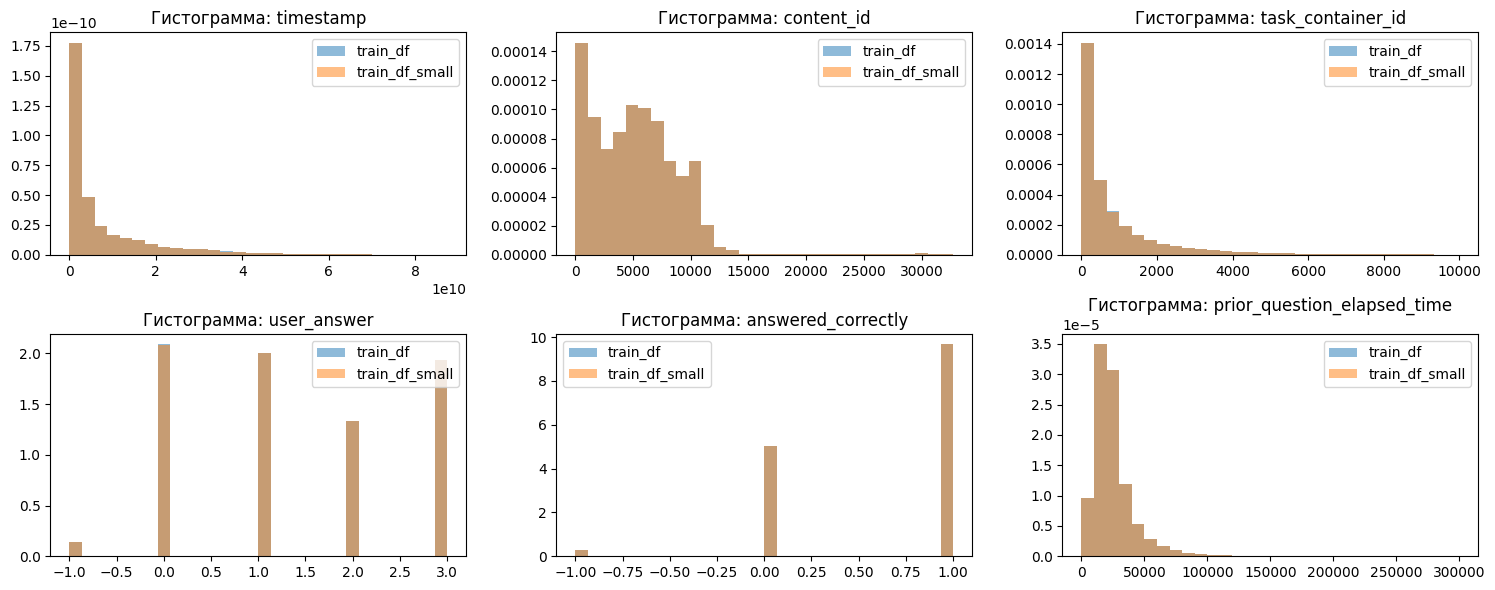

In [41]:
numeric_columns = ['timestamp', 'content_id', 'task_container_id', 'user_answer', 'answered_correctly', 'prior_question_elapsed_time']

def compare_statistics(train_df, train_df_small, numeric_columns):
    for column in numeric_columns:
        print(f"\n{column}:")
        print(f"train_df: mean={train_df[column].mean():.2f}, std={train_df[column].std():.2f}")
        print(f"train_df_small: mean={train_df_small[column].mean():.2f}, std={train_df_small[column].std():.2f}")

def compare_histograms_in_grid(train_df, train_df_small, numeric_columns):
    num_columns = len(numeric_columns)
    rows = (num_columns // 4) + (num_columns % 4 > 0)

    plt.figure(figsize=(15, 3 * rows))

    for i, column in enumerate(numeric_columns):
        plt.subplot(rows, 3, i + 1)
        plt.hist(train_df[column], bins=30, alpha=0.5, label='train_df', density=True)
        plt.hist(train_df_small[column], bins=30, alpha=0.5, label='train_df_small', density=True)
        plt.title(f"Гистограмма: {column}")
        plt.legend()

    plt.tight_layout()
    plt.show()

compare_statistics(train_df, train_df_small, numeric_columns)

compare_histograms_in_grid(train_df, train_df_small, numeric_columns)

## Изучение и предобработка данных.

Сделаем копии таблиц для дальнейшей работы и приобразований.

In [42]:
train = train_df_small.copy()
lectures = lectures_df.copy()
questions = questions_df.copy()

In [43]:
def df_summary(df):
    print("DataFrame Info:")
    print(df.info())
    print("\n" + "="*50 + "\n")

    print("First 5 rows of the DataFrame:")
    display(df.head())
    print("\n" + "="*50 + "\n")

    print("Sum of NaNs for each column:")
    print(df.isna().sum())
    print("\n" + "="*50 + "\n")

In [44]:
df_summary(lectures)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   lecture_id  418 non-null    int64 
 1   tag         418 non-null    int64 
 2   part        418 non-null    int64 
 3   type_of     418 non-null    object
dtypes: int64(3), object(1)
memory usage: 13.2+ KB
None


First 5 rows of the DataFrame:


,lecture_id,tag,part,type_of
0,89,159,5,concept
1,100,70,1,concept
2,185,45,6,concept
3,192,79,5,solving question
4,317,156,5,solving question




Sum of NaNs for each column:
lecture_id    0
tag           0
part          0
type_of       0
dtype: int64




In [45]:
df_summary(questions)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13523 entries, 0 to 13522
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   question_id     13523 non-null  int64 
 1   bundle_id       13523 non-null  int64 
 2   correct_answer  13523 non-null  int64 
 3   part            13523 non-null  int64 
 4   tags            13522 non-null  object
dtypes: int64(4), object(1)
memory usage: 528.4+ KB
None


First 5 rows of the DataFrame:


,question_id,bundle_id,correct_answer,part,tags
0,0,0,0,1,51 131 162 38
1,1,1,1,1,131 36 81
2,2,2,0,1,131 101 162 92
3,3,3,0,1,131 149 162 29
4,4,4,3,1,131 5 162 38




Sum of NaNs for each column:
question_id       0
bundle_id         0
correct_answer    0
part              0
tags              1
dtype: int64




In [46]:
df_summary(train)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
Index: 5061516 entries, 18420111 to 8324845
Data columns (total 10 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   row_id                          int64  
 1   timestamp                       int64  
 2   user_id                         int64  
 3   content_id                      int64  
 4   content_type_id                 int64  
 5   task_container_id               int64  
 6   user_answer                     int64  
 7   prior_question_elapsed_time     float64
 8   prior_question_had_explanation  object 
 9   answered_correctly              int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 424.8+ MB
None


First 5 rows of the DataFrame:


,row_id,timestamp,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_elapsed_time,prior_question_had_explanation,answered_correctly
18420111,18420111,160783392,395540520,5611,0,87,0,13000.0,True,1
92716925,92716925,8971017252,1967273276,5580,0,2532,1,49000.0,True,1
88768132,88768132,5233215641,1887573495,7936,0,96,3,27000.0,True,1
100316495,100316495,981578903,2129518860,3651,0,235,0,9000.0,True,1
52622416,52622416,1911219909,1115327928,7932,0,183,2,18000.0,True,1




Sum of NaNs for each column:
row_id                                 0
timestamp                              0
user_id                                0
content_id                             0
content_type_id                        0
task_container_id                      0
user_answer                            0
prior_question_elapsed_time       117344
prior_question_had_explanation     19392
answered_correctly                     0
dtype: int64




В таблице `train` столбец `row_id` дублирует индекс, его можно удалить, `timestemp` и `prior_question_elapsed_time` переведем в минуты (для большей понятности)

In [47]:
train['timestamp_in_minutes'] = train['timestamp'] / 60000
train['prior_question_elapsed_time_in_minutes'] = train['prior_question_elapsed_time'] / 60000
train.drop(['row_id', 'timestamp', 'prior_question_elapsed_time'], axis=1, inplace=True)

In [48]:
train.head()

,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_had_explanation,answered_correctly,timestamp_in_minutes,prior_question_elapsed_time_in_minutes
18420111,395540520,5611,0,87,0,True,1,2679.723200,0.216667
92716925,1967273276,5580,0,2532,1,True,1,149516.954200,0.816667
88768132,1887573495,7936,0,96,3,True,1,87220.260683,0.450000
100316495,2129518860,3651,0,235,0,True,1,16359.648383,0.150000
52622416,1115327928,7932,0,183,2,True,1,31853.665150,0.300000


## Уточнение задачи.

В задании сказано, что нам нужно проанализировать как можно больше характеристик, влияющих на успеваемость студентов. Покакзателем успеваемости в таблицах является столбец `answered_correctly` из таблицы `train`, соответственно мы будем изучать как эта переменная взаимосвязана с другими данными.

In [49]:
train['answered_correctly'].value_counts()

,count
answered_correctly,
1,3262231
0,1701333
-1,97952


## Анализ характеристик, влияющих на успеваемость.

### Время взаимодействия студента с платформой vs успеваемость

Проверим корректность данных в столбце `'timestamp'`

In [50]:
print(len(train[train['timestamp_in_minutes'] < 0]))

0


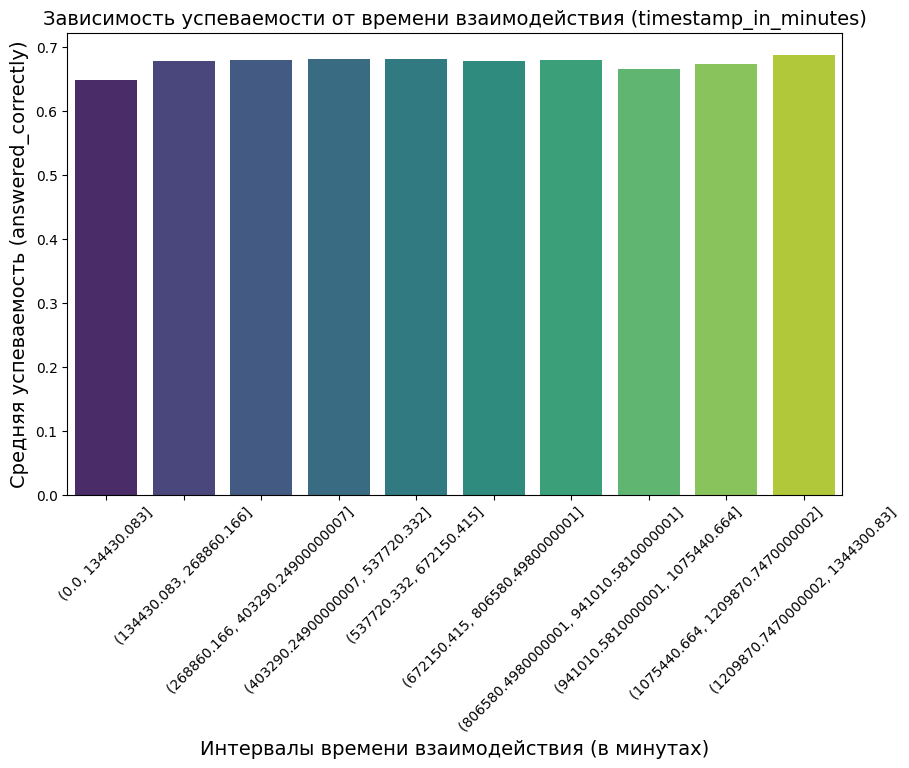

In [51]:
train_filtered = train[train['content_type_id'] == 0]
bins = pd.interval_range(start=0, end=train['timestamp_in_minutes'].max(), freq=134430.083)
timestamp_performance_analysis = train_filtered.groupby(pd.cut(train_filtered['timestamp_in_minutes'], bins=bins))['answered_correctly'].mean()

plt.figure(figsize=(10, 6))
sns.barplot(x=timestamp_performance_analysis.index, y=timestamp_performance_analysis.values, palette='viridis')
plt.title('Зависимость успеваемости от времени взаимодействия (timestamp_in_minutes)', fontsize=14)
plt.xlabel('Интервалы времени взаимодействия (в минутах)', fontsize=14)
plt.ylabel('Средняя успеваемость (answered_correctly)', fontsize=14)
plt.xticks(rotation=45)
plt.show()

# timestamp_performance_analysis

- **Успеваемость студентов** (в виде среднего значения столбца `answered_correctly`) слегка варьируется в зависимости от интервалов времени взаимодействия (`timestamp_in_minutes`), но явных резких изменений или трендов не наблюдается.

### Тип контента.

Посмотрим, как тип контента (вопрос или лекция) связан с правильными ответами студентов.

In [52]:
content_type_analysis = train[train['content_type_id'] == 0].groupby('content_type_id')['answered_correctly'].mean()
print('Влияние типа контента на успеваемость:')
print(content_type_analysis)

Влияние типа контента на успеваемость:
content_type_id
0    0.657236
Name: answered_correctly, dtype: float64


`content_type_id = 0`: Это вопросы, на которые студенты отвечали. Средняя успеваемость по этим вопросам составляет `0.657`, что означает, что студенты в среднем отвечали правильно примерно на `65.7%` вопросов.

### Время затраченное на предыдущие вопросы и успеваемость.

Зассмотрим, как время, затраченное на предыдущие вопросы (через переменную `prior_question_elapsed_time_in_minutes`), влияет на успеваемость.

prior_question_elapsed_time_in_minutes
(-0.005, 0.5]    0.662037
(0.5, 1.0]       0.640698
(1.0, 1.5]       0.649252
(1.5, 2.0]       0.637954
(2.0, 2.5]       0.628812
(2.5, 3.0]       0.635371
(3.0, 3.5]       0.616910
(3.5, 4.0]       0.603273
(4.0, 4.5]       0.619005
(4.5, 5.0]       0.618859
Name: answered_correctly, dtype: float64


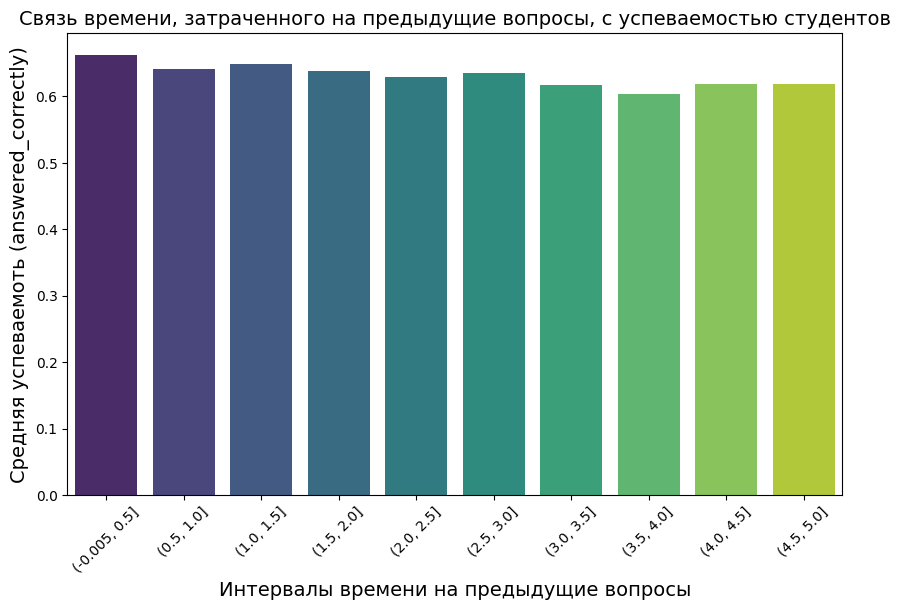

In [53]:
elapsed_time_analysis = train.groupby(pd.cut(train['prior_question_elapsed_time_in_minutes'], bins=10))['answered_correctly'].mean()
print(elapsed_time_analysis)

plt.figure(figsize=(10, 6))
sns.barplot(x=elapsed_time_analysis.index, y=elapsed_time_analysis.values, palette='viridis')

plt.title('Связь времени, затраченного на предыдущие вопросы, с успеваемостью студентов', fontsize=14)
plt.xlabel('Интервалы времени на предыдущие вопросы', fontsize=14)
plt.ylabel('Средняя успеваемоть (answered_correctly)', fontsize=14)

plt.xticks(rotation=45)
plt.show()

- **Время**, затраченное на вопросы, оказывает умеренное влияние на успеваемость: наилучшие результаты (**66.2%**) наблюдаются при времени ответа до **0.5 минут**, а ответы дольше **4 минут** показывают незначительное снижение точности до **61.9%**.Это скорее говорит о том, что при знании точного и правильного ответа студенту не нужно много времени на ответ.


### Просмотр объяснений и успеваемость.

Посмотрим, как факт просмотра объяснений (переменная prior_question_had_explanation) влияет на успеваемость студентов.

prior_question_had_explanation
False    0.237931
True     0.673112
Name: answered_correctly, dtype: float64


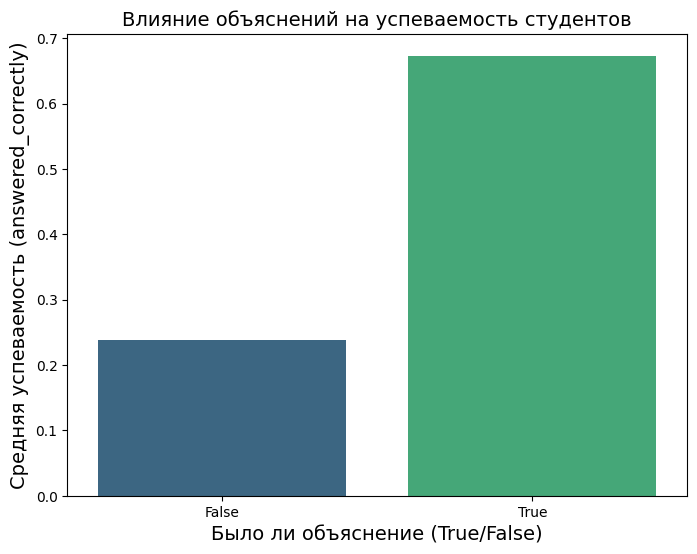

In [54]:
explanation_analysis = train.groupby('prior_question_had_explanation')['answered_correctly'].mean()
print(explanation_analysis)

plt.figure(figsize=(8, 6))
sns.barplot(x=explanation_analysis.index, y=explanation_analysis.values, palette='viridis')

plt.title('Влияние объяснений на успеваемость студентов', fontsize=14)
plt.xlabel('Было ли объяснение (True/False)', fontsize=14)
plt.ylabel('Средняя успеваемость (answered_correctly)', fontsize=14)

plt.show()

- **Когда объяснение не было показано (False)**: Средняя успеваемость составляет **23.79%**. Это довольно низкий результат, что может свидетельствовать о том, что отсутствие объяснений значительно снижает вероятность правильного ответа.

- **Когда объяснение было показано (True)**: Средняя успеваемость составляет **67.31%**. Это существенно выше, что указывает на то, что просмотр объяснений заметно улучшает результаты студентов.

Наличие объяснений играет важную роль в повышении успеваемости студентов. Те студенты, которые видели объяснения после ответов, чаще дают правильные ответы на вопросы.


### Опыт и успеваемость.

Изучим, как различные пользователи отвечают на вопросы и проанализируем влияние опыта или количества вопросов на их успеваемость.

,question,lecture,average_performance
user_id,,,
115,2,0,1.000000
2746,1,0,1.000000
5382,5,0,0.800000
8623,3,0,0.666667
12741,12,0,0.416667


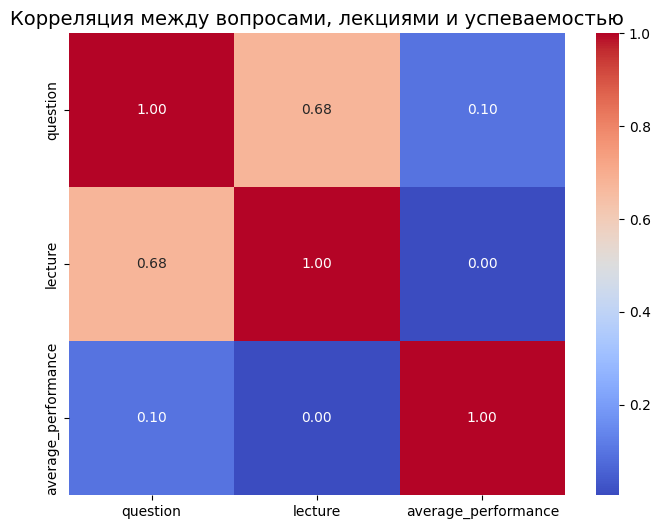

In [55]:
pivot_content_interactions = train.pivot_table(
    values='content_id',
    index='user_id',
    columns='content_type_id',
    aggfunc='count',
    fill_value=0
)

user_performance = train.groupby('user_id')['answered_correctly'].mean()
pivot_content_with_performance = pivot_content_interactions.join(user_performance, on='user_id')
# 0 if the event was a question being posed to the user.
# 1 if the event was the user watching a lecture.
pivot_content_with_performance.rename(columns={ 0: 'question',  1: 'lecture', 'answered_correctly': 'average_performance'}, inplace=True)
display(pivot_content_with_performance.head())

plt.figure(figsize=(8, 6))
correlation = pivot_content_with_performance[['question', 'lecture', 'average_performance']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')

plt.title('Корреляция между вопросами, лекциями и успеваемостью', fontsize=14)
plt.show()

- **Средняя положительная корреляция (0.68) между количеством вопросов и лекций**:
  Это означает, что пользователи, которые ответили на большее количество вопросов, также чаще просматривали лекции. Пользователи, активно взаимодействующие с вопросами, также взаимодействуют с лекциями.

- **Очень слабая положительная корреляция (0.10) между количеством вопросов и успеваемостью**:
  Количество вопросов, на которые ответил пользователь, лишь слабо связано с его успеваемостью. Это может указывать на то, что большое количество вопросов не всегда приводит к более высоким результатам.

- **Отсутствие корреляции (0.00) между количеством лекций и успеваемостью**:
  Лекции, судя по данным, не имеют значимого влияния на успеваемость. Это может означать, что количество просмотренных лекций само по себе не является решающим фактором успеха.

Активное участие в вопросах и лекциях не всегда напрямую связано с высокой успеваемостью. Другие факторы, такие как качество взаимодействий или наличие объяснений, могут оказывать более сильное влияние на результаты.



### Выявленеи сложности наборов вопросов `task_container_id`.

Проанализируем `task_container_id` на основе успеваемости для выявления наиболее сложных и легких наборов вопросов

- **task_container_id**: (int16) ID code for the batch of questions or lectures. For example, a user might see three questions in a row before seeing the explanations for any of them. Those three would all share a `task_container_id`.

Отфильтруем `task_container_id` по вопросам и найдем самые сложные наборы.

In [71]:
task_container_performance = train[train['content_type_id'] == 0].groupby('task_container_id')['answered_correctly'].mean()
task_container_performance_sorted = pd.DataFrame(task_container_performance.sort_values(ascending=False))

print("Самые сложные task_container_id:")
display(task_container_performance_sorted.tail())

print("\nСамые легкие task_container_id:")
(task_container_performance_sorted.head())

Самые сложные task_container_id:


,answered_correctly
task_container_id,
9329,0.250000
9592,0.200000
9254,0.166667
9524,0.166667
9898,0.125000



Самые легкие task_container_id:


,answered_correctly
task_container_id,
9999,1.0
9078,1.0
9778,1.0
9779,1.0
9186,1.0


- **Самые сложные наборы вопросов (task_container_id):**
  Наборы, такие как **9329**, **9592**, **9254**, **9524**, и **9898**, имеют низкую среднюю успеваемость (от **12.5%** до **25%**). Эти вопросы оказались сложными для студентов в данной выборке, что может указывать на их повышенную сложность или недостаточное понимание темы студентами.

- **Самые легкие наборы вопросов (task_container_id):**
  Наборы, такие как **9999**, **9078**, **9778**, **9779**, и **9186**, имеют среднюю успеваемость **100%**, что означает, что все студенты ответили на них правильно. Эти вопросы оказались слишком легкими или хорошо понятными для студентов в данной выборке.

### Вопросы с низкой и высокой успеваемостью `content_id`

Проанализируем `content_id` на основе успеваемости для выявления наиболее сложных и легких вопросов.

- **content_id**: (int16) ID code for the user interaction.

In [72]:
content_performance = train[train['content_type_id'] == 0].groupby('content_id')['answered_correctly'].mean()
content_performance_sorted = pd.DataFrame(content_performance.sort_values())

print("Самые сложные content_id:")
display(content_performance_sorted[content_performance_sorted['answered_correctly'] == 0.0])

print("\nСамые легкие content_id:")
content_performance_sorted[content_performance_sorted['answered_correctly'] == 1.0]

Самые сложные content_id:


,answered_correctly
content_id,
2076,0.0
7365,0.0
13111,0.0
13101,0.0
13097,0.0
6223,0.0
13062,0.0
13157,0.0
13048,0.0



Самые легкие content_id:


,answered_correctly
content_id,
2795,1.0
566,1.0
12655,1.0
12631,1.0
616,1.0
...,...
2270,1.0
2269,1.0
13181,1.0


- **Самые сложные вопросы (content_id):**
  Всего **18** вопросов в данной выборке имеют среднюю успеваемость **0%**, что указывает на то, что ни один студент не дал правильного ответа. Эти вопросы могут быть слишком сложными или плохо поняты студентами.

- **Самые легкие вопросы (content_id):**
  **460** вопросов в выборке имеют среднюю успеваемость **100%**, что означает, что все студенты ответили на них правильно. Эти вопросы могут быть слишком простыми или хорошо известными студентам.


### Самые популярные вопросы с наименьшей успеваемостью.

In [73]:
question_performance = train[train['content_type_id'] == 0].groupby('content_id').agg(
    attempts=('answered_correctly', 'count'),
    mean_correctness=('answered_correctly', 'mean')
)

popular_low_performance_questions = question_performance[question_performance['mean_correctness'] < 0.1].sort_values(by='attempts', ascending=False)
popular_low_performance_questions.head(10)

,attempts,mean_correctness
content_id,,
10062,367,0.084469
2747,11,0.090909
7365,6,0.000000
13218,6,0.000000
12769,5,0.000000
13101,5,0.000000
5759,4,0.000000
13097,4,0.000000
13157,3,0.000000


- **Самый популярный вопрос с низкой успеваемостью** — это вопрос с `content_id = 10062`, который был популярен с 375 попытками, но лишь **8%** студентов ответили на него правильно. Остальные вопросы имеют еще более низкие показатели, некоторые даже с нулевой успеваемостью, несмотря на некоторое количество попыток, что может указывать на их высокую сложность.


### Успеваемость и разделы теста.

Теперь с помощью объединения таблиц посмотрим успеваемость по разделам `TOEIC`

- **question_id**: Foreign key for the train/test `content_id` column, when the content type is question (0).
- **part**: The relevant section of the TOEIC test.

Средняя успеваемость по разделам TOEIC:


,answered_correctly
part,
1,0.721101
2,0.700994
3,0.686555
6,0.654291
7,0.652024
4,0.610286
5,0.599255


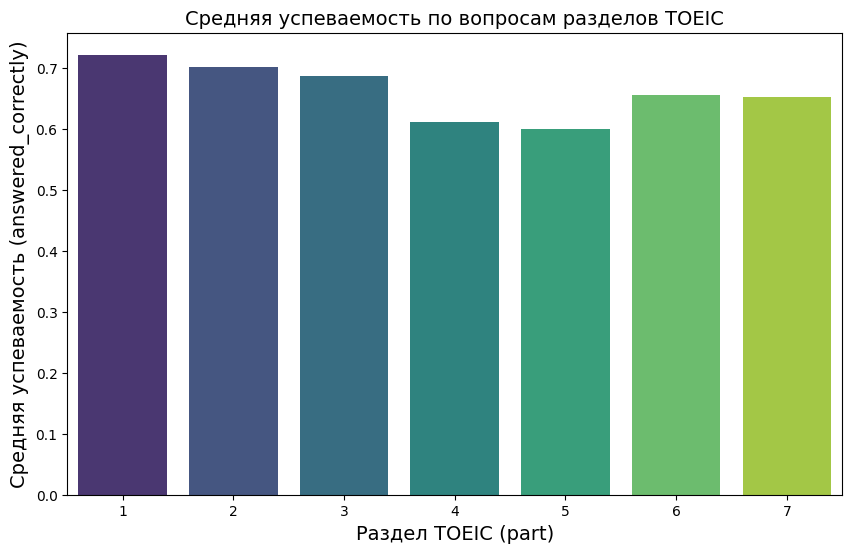

In [74]:
merged_train_questions = pd.merge(train, questions, left_on='content_id', right_on='question_id', how='inner')
merged_train_questions.head()

toeic_performance = merged_train_questions.groupby('part')['answered_correctly'].mean()
toeic_performance.sort_values(ascending=False, inplace=True)

print("Средняя успеваемость по разделам TOEIC:")
display(toeic_performance)

plt.figure(figsize=(10, 6))
sns.barplot(x=toeic_performance.index, y=toeic_performance.values, palette='viridis')

plt.title('Средняя успеваемость по вопросам разделов TOEIC', fontsize=14)
plt.xlabel('Раздел TOEIC (part)', fontsize=14)
plt.ylabel('Средняя успеваемость (answered_correctly)', fontsize=14)

plt.xticks(rotation=0)
plt.show()

1. **Раздел 1:** Средняя успеваемость составляет **72.11%**, что делает его наиболее успешным разделом для студентов. Это может говорить о том, что задания в этом разделе легче или студенты лучше подготовлены к вопросам этого раздела.

2. **Раздел 2:** Средняя успеваемость **70.10%**, что также свидетельствует о высоком уровне понимания вопросов студентами.

3. **Раздел 3:** Средняя успеваемость **68.66%**, что указывает на хорошие результаты, но немного ниже по сравнению с первыми двумя разделами.

4. **Разделы 6 и 7:** Успеваемость составляет **65.43%** и **65.20%** соответственно. Эти разделы можно отнести к средней сложности, так как результаты здесь немного ниже, но все еще на хорошем уровне.

5. **Раздел 4:** Успеваемость **61.03%**, что указывает на более сложные задания для студентов.

6. **Раздел 5:** Показал самую низкую среднюю успеваемость — **59.93%**. Это может свидетельствовать о том, что задания в этом разделе требуют дополнительной подготовки или являются более сложными для понимания.

Таким образом, студенты лучше всего справляются с вопросами из разделов 1 и 2, а раздел 5 является наиболее сложным для них. Это может быть полезно при планировании дополнительных занятий по темам, связанным с разделом 5.


### Phik корреляция

interval columns not set, guessing: ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly', 'timestamp_in_minutes', 'prior_question_elapsed_time_in_minutes', 'question_id', 'bundle_id', 'correct_answer', 'part']


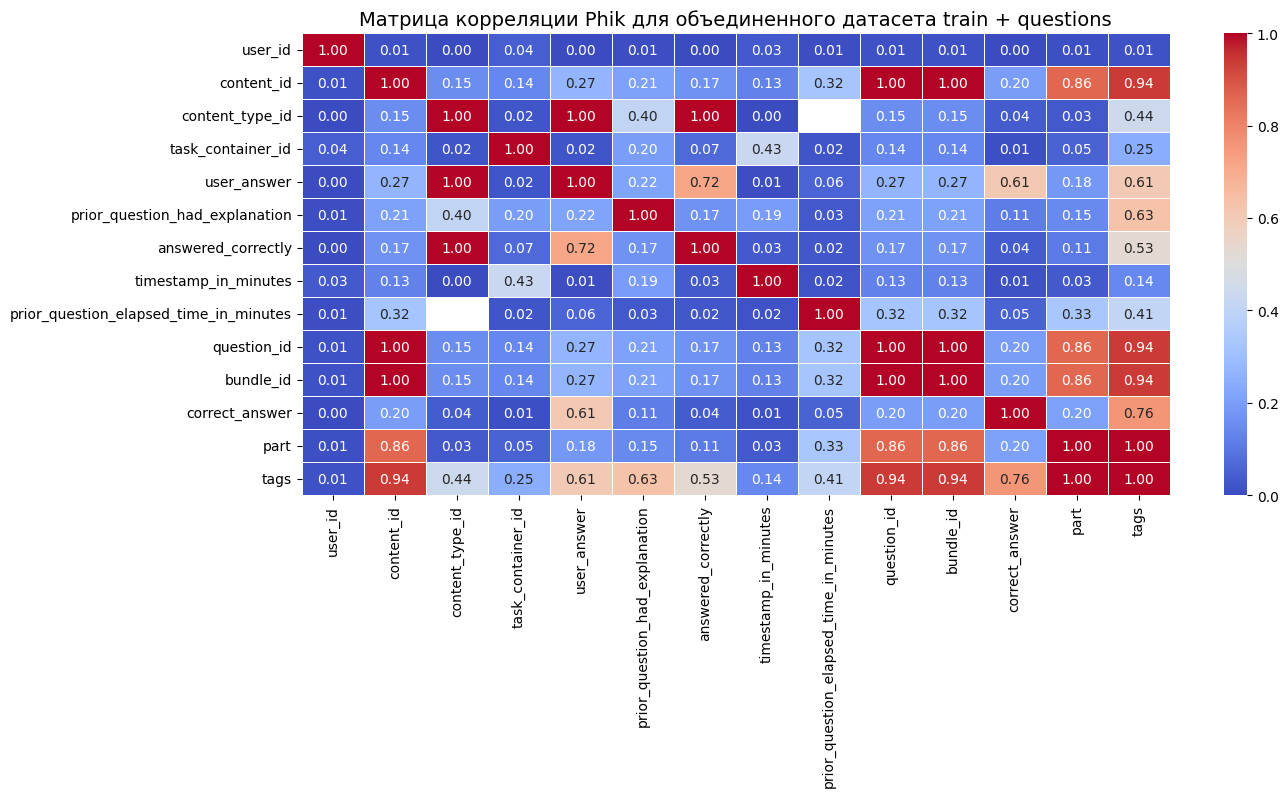

In [75]:
phik_matrix = merged_train_questions.phik_matrix()

plt.figure(figsize=(14, 6))
sns.heatmap(phik_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляции Phik для объединенного датасета train + questions', fontsize=14)
plt.show()

- **`correct_answer` и `tags` (0.76)**: Относительно сильная корреляция с тегами вопросов. Это может указывать на то, что определённые типы вопросов (обозначенные тегами) имеют более предсказуемые или вероятные правильные ответы.

Корреляция между правильными ответами (`correct_answer`) и другими признаками в целом невысокая, что может говорить о том, что правильный ответ не сильно зависит от таких факторов, как время на вопросы или группы вопросов. Однако существуют умеренные зависимости с тегами вопросов и разделами TOEIC, что указывает на возможное влияние типа вопросов на вероятность правильного ответа.

## Объединение всех таблиц в одну.

Объединим все датасеты в один, оставив все строки в `train`.

In [76]:
merged_df = pd.merge(train, questions, left_on='content_id', right_on='question_id', how='left')
merged_df = pd.merge(merged_df, lectures, left_on='content_id', right_on='lecture_id', how='left')
merged_df.drop(['question_id', 'lecture_id'], axis=1, inplace=True)
merged_df.rename(columns={'part_x': 'TOEIC_section', 'part_y': 'lecture_category_code'}, inplace=True)

print(merged_df.info())
merged_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5061516 entries, 0 to 5061515
Data columns (total 16 columns):
 #   Column                                  Dtype  
---  ------                                  -----  
 0   user_id                                 int64  
 1   content_id                              int64  
 2   content_type_id                         int64  
 3   task_container_id                       int64  
 4   user_answer                             int64  
 5   prior_question_had_explanation          object 
 6   answered_correctly                      int64  
 7   timestamp_in_minutes                    float64
 8   prior_question_elapsed_time_in_minutes  float64
 9   bundle_id                               float64
 10  correct_answer                          float64
 11  TOEIC_section                           float64
 12  tags                                    object 
 13  tag                                     float64
 14  lecture_category_code             

,user_id,content_id,content_type_id,task_container_id,user_answer,prior_question_had_explanation,answered_correctly,timestamp_in_minutes,prior_question_elapsed_time_in_minutes,bundle_id,correct_answer,TOEIC_section,tags,tag,lecture_category_code,type_of
0,395540520,5611,0,87,0,True,1,2679.723200,0.216667,5611.0,0.0,5.0,64,NaN,NaN,NaN
1,1967273276,5580,0,2532,1,True,1,149516.954200,0.816667,5580.0,1.0,5.0,8,NaN,NaN,NaN
2,1887573495,7936,0,96,3,True,1,87220.260683,0.450000,7936.0,3.0,1.0,10 164 162 29,NaN,NaN,NaN
3,2129518860,3651,0,235,0,True,1,16359.648383,0.150000,3651.0,0.0,5.0,55,NaN,NaN,NaN
4,1115327928,7932,0,183,2,True,1,31853.665150,0.300000,7932.0,2.0,1.0,131 93 162 29,NaN,NaN,NaN


### Ответы пользователей vs правильные ответы

Посмотрим и перепроверим по объединенной таблице правильные ответы на вопросы и ответы пользователей.

In [77]:
merged_df['user_correct'] = (merged_df['user_answer'] == merged_df['correct_answer']).astype(int)

display(merged_df[['user_answer', 'correct_answer', 'user_correct']].head())

correct_count = merged_df['user_correct'].sum()
total_answers = merged_df['user_correct'].count()
accuracy = correct_count / total_answers

print(f"Общее количество ответов: {total_answers}")
print(f"Количество правильных ответов: {correct_count}")
print(f"Точность (процент правильных ответов): {accuracy:.2%}")

display(merged_df[['user_answer', 'correct_answer', 'user_correct', 'answered_correctly']].head())
print(f"Длина несоответствия правильных ответов в train и questions: {len(merged_df[(merged_df['answered_correctly'] != merged_df['user_correct']) & (merged_df['answered_correctly'] == 1)])}")

,user_answer,correct_answer,user_correct
0,0,0.0,1
1,1,1.0,1
2,3,3.0,1
3,0,0.0,1
4,2,2.0,1


Общее количество ответов: 5061516
Количество правильных ответов: 3262231
Точность (процент правильных ответов): 64.45%


,user_answer,correct_answer,user_correct,answered_correctly
0,0,0.0,1,1
1,1,1.0,1,1
2,3,3.0,1,1
3,0,0.0,1,1
4,2,2.0,1,1


Длина несоответствия правильных ответов в train и questions: 0


В выборке не найдены несоответствия между двумя наборами данных.

### Успеваемость и наличие разъяснений в соответствии разделам TOEIC test


Создадим сводную таблицу для анализа зависимости успеваемости и соответствующими разделами `TOEIC test`.

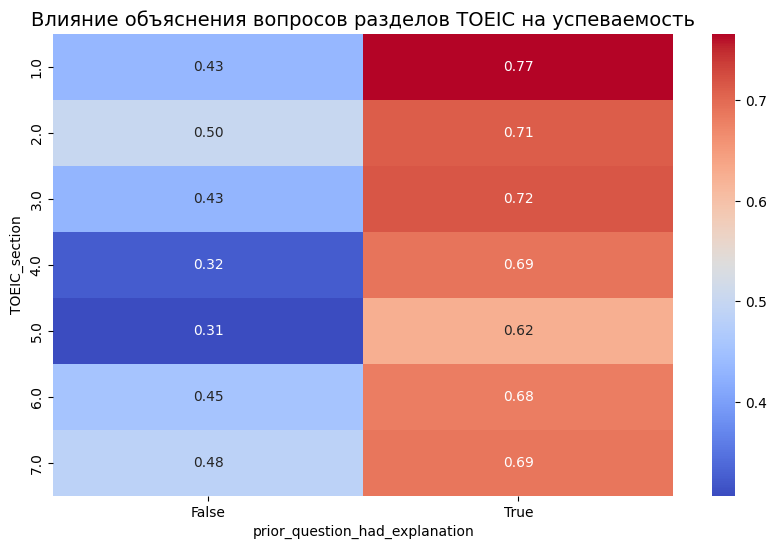

In [63]:
pivot_table = merged_df.pivot_table(
    values='answered_correctly',
    index='TOEIC_section',
    columns='prior_question_had_explanation',
    aggfunc='mean',
    fill_value=0
)

plt.figure(figsize=(10, 6))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Влияние объяснения вопросов разделов TOEIC на успеваемость', fontsize=14)
plt.show()

- **Высокая успеваемость при наличии объяснений:** При наличии объяснений (столбец `True`), успеваемость значительно выше во всех разделах TOEIC. Например, в разделе 1 она достигает **77%**, что является наивысшим показателем.

- **Низкая успеваемость без объяснений:** Без объяснений (столбец `False`), успеваемость значительно ниже. В некоторых разделах, таких как раздел 4 и 5, она падает до **32%** и **31%** соответственно.

- **Разделы 4 и 5** показывают самые низкие результаты как с объяснением, так и без него, что может свидетельствовать о повышенной сложности этих разделов для студентов.

Наличие объяснений заметно улучшает результаты студентов во всех разделах TOEIC, особенно в разделах 1, 2 и 3, где разница между успеваемостью с объяснениями и без них наиболее заметна.



### Phik для объединенной таблицы

interval columns not set, guessing: ['user_id', 'content_id', 'content_type_id', 'task_container_id', 'user_answer', 'answered_correctly', 'timestamp_in_minutes', 'prior_question_elapsed_time_in_minutes', 'bundle_id', 'correct_answer', 'TOEIC_section', 'tag', 'lecture_category_code', 'user_correct']


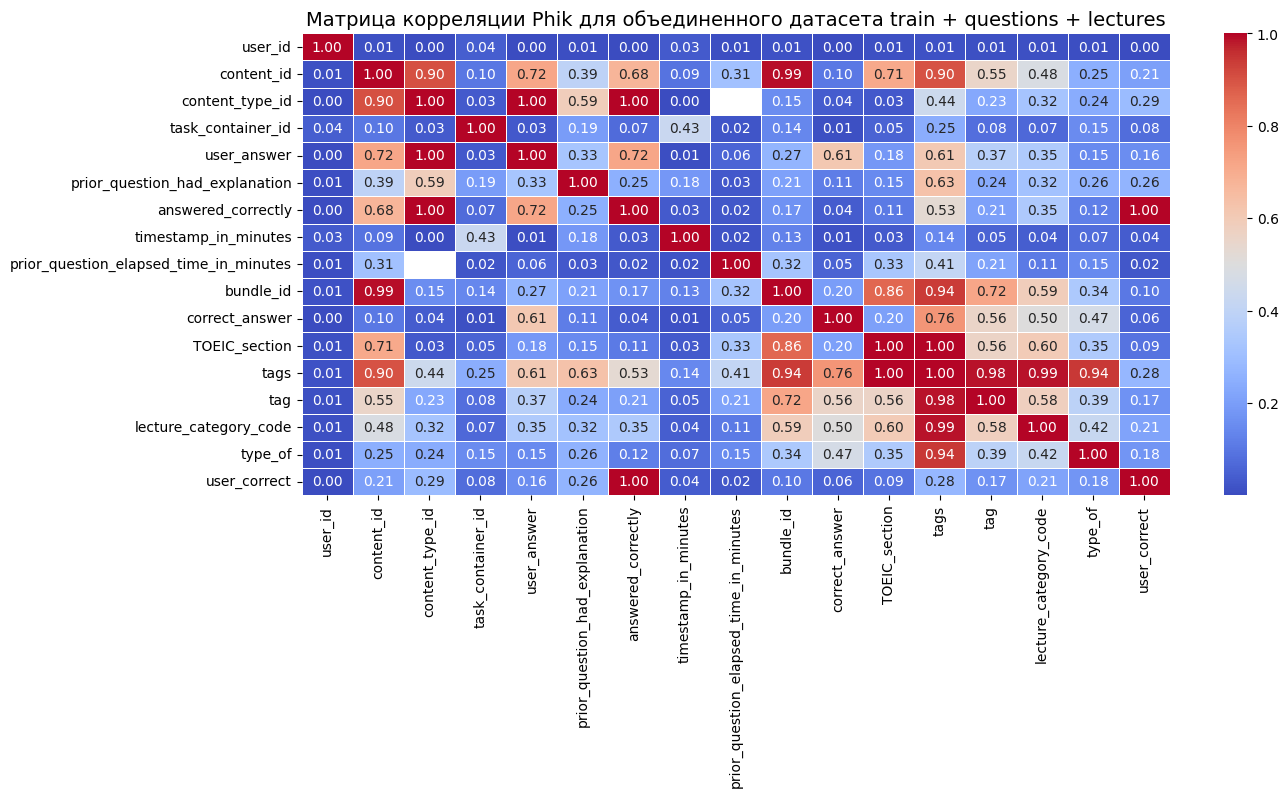

In [78]:
phik_matrix_merged = merged_df.phik_matrix()

plt.figure(figsize=(14, 6))
sns.heatmap(phik_matrix_merged, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Матрица корреляции Phik для объединенного датасета train + questions + lectures', fontsize=14)
plt.show()

**`tag`** из лекций и **`tags`** из вопросов вероятно описывают схожие или совпадающие темы, что объясняет высокую корреляцию. Лекции и вопросы могут быть связаны общей тематикой, либо теги организованы по одинаковым категориям, что делает их связанными. Попробуем разобраться какие таги являются самыми сложными для судентов при ответе на вопросы и лекции с какими тагами они просматривают больше всего.

В таблице вопросов помимо данных о самих вопросах, есть другой признак, который их группирует, рассмотрим на какие группы вопросов студенты отвечают лучше и хуже.

- **question_id**: Foreign key for the train/test `content_id` column, when the content type is question (0).
- **bundle_id**: Code for which questions are served together.

In [80]:
merged_df[merged_df['content_type_id'] == 0].groupby('bundle_id')['content_id'].count().sort_values(ascending=False).head()

question_data = merged_df[merged_df['content_type_id'] == 0]
bundle_performance = question_data.groupby('bundle_id')['answered_correctly'].mean().sort_values(ascending=False)

print("Наборы с самой высокой успеваемостью:")
display(bundle_performance.head())

print("\nНаборы с самой низкой успеваемостью:")
bundle_performance.tail()

Наборы с самой высокой успеваемостью:


,answered_correctly
bundle_id,
12596.0,1.0
12905.0,1.0
12783.0,1.0
11881.0,1.0
12911.0,1.0



Наборы с самой низкой успеваемостью:


,answered_correctly
bundle_id,
13341.0,0.125000
12705.0,0.111111
6223.0,0.000000
5759.0,0.000000
12769.0,0.000000


- **Анализ успеваемости по наборам вопросов** показывает, что есть группы с очень высокой (100%) и очень низкой успеваемостью (до 0%), что важно учитывать для настройки контента: эффективные наборы могут быть использованы для подтверждения знаний, а сложные — для дополнительного пересмотра или улучшения.


### Работа с `tag`  и `tags`

In [81]:
question_tags_performance = merged_df[merged_df['content_type_id'] == 0].groupby('tags')['answered_correctly'].mean()
question_tags_performance_sorted = question_tags_performance.sort_values()

print("Самые сложные теги для вопросов:")
display(question_tags_performance_sorted.head())

lecture_tags_popularity = merged_df[merged_df['content_type_id'] == 1].groupby('tag')['user_id'].count()
lecture_tags_popularity_sorted = lecture_tags_popularity.sort_values(ascending=False)

print("\nСамые популярные теги для лекций:")
display(lecture_tags_popularity_sorted.head())

Самые сложные теги для вопросов:


,answered_correctly
tags,
118 42 21 162,0.123894
106 67 162 92,0.199688
98 117 135 165,0.217391
161 150 162 81,0.220120
161 83 29,0.253343



Самые популярные теги для лекций:


,user_id
tag,
62.0,2892
27.0,2754
163.0,2177
136.0,2090
161.0,1997


В коде сверху были отфильтрованы строки с самыми популярными темами лекций и сложными темами вопросов.

В дальнейшем можно сопоставить теги по сложности вопросов и популярности лекций. Если подтвердится предположение, что они совпадают, это может означать, что значения тегов в таблице `lectures` и таблице `questions` относятся к одним и тем же темам, которые трудны для студентов, но активно изучаются через лекции. Это открывает возможность для улучшения учебного контента по этим темам с добавлением дополнительных объяснений и материалов.


## Заключение

В результате проведенного анализа данных об успеваемости студентов были выявлены ключевые факторы, влияющие на их результаты, а также определены возможные области для улучшения учебного процесса. Рассмотрим основные выводы:

1. **Тип контента и успеваемость**:
   - Средняя успеваемость по вопросам составляет **65.7%**, что является хорошим показателем, но требует дополнительного внимания к сложным вопросам и наборам.

2. **Влияние времени на вопросы**:
   - Время, затраченное на вопросы, оказывает умеренное влияние на успеваемость. Наилучшие результаты наблюдаются при быстром ответе (до **0.5 минут**), с точностью **66.2%**, тогда как ответы дольше **4 минут** приводят к небольшому снижению точности до **61.9%**.

3. **Роль объяснений**:
   - Наличие объяснений значительно повышает успеваемость. Студенты, которые видели объяснения, отвечали правильно в **67.31%** случаев, в то время как те, кто не видел объяснений, показали значительно более низкую успеваемость — всего **23.79%**. Это подчеркивает важность объяснений для понимания учебного материала.

4. **Анализ разделов теста TOEIC**:
   - Успеваемость студентов варьируется в зависимости от разделов. Раздел 1 является самым успешным с успеваемостью **72.11%**, тогда как раздел 5 показал самые низкие результаты — **59.93%**. Это указывает на необходимость дополнительной подготовки к заданиям раздела 5.

5. **Корреляция между вопросами и лекциями**:
   - Обнаружена слабая положительная корреляция между количеством вопросов и лекций (**0.68**), а также между количеством вопросов и успеваемостью (**0.10**). Лекции сами по себе не оказывают значительного влияния на успеваемость (**0.00**), но их взаимосвязь с вопросами может быть полезна для улучшения учебного процесса.

6. **Анализ сложности вопросов и наборов**:
   - Некоторые наборы вопросов (task_container_id) и отдельные вопросы (content_id) показали либо очень высокую, либо очень низкую успеваемость. Это может свидетельствовать о необходимости пересмотра сложных вопросов или уточнения их формулировок.

7. **Phik-корреляция и теги**:
   - Применение Phik-корреляции выявило значимые связи между тегами лекций и вопросов. Например, теги вопросов и правильные ответы коррелируют на уровне **0.76**, что подчеркивает важность организации контента по темам для повышения успеваемости студентов.

8. **Популярные и сложные теги**:
   - Анализ тегов выявил, что некоторые из самых сложных для студентов тегов вопросов совпадают с популярными тегами лекций. Это открывает возможность для улучшения учебного процесса путем детального анализа сложных тем и предоставления дополнительных материалов.

### Заключительный вывод:
Активность студентов в вопросах и лекциях, наличие объяснений, время на ответы и структура разделов теста — все это влияет на успеваемость студентов. Важно обратить внимание на разделы с низкой успеваемостью, такие как раздел 5 TOEIC, и темы с высокими показателями сложности, чтобы улучшить учебный процесс и адаптировать контент к потребностям студентов. Анализ тегов вопросов и лекций позволит улучшить поддержку сложных тем, что в конечном итоге может повысить общую успеваемость.
